# [MKP] - Hypothesis, Annotations, and Engagement

In [294]:
import datetime
import json
import re
from statistics import mean, median
from pathlib import Path

from tabulate import tabulate
import matplotlib as mpl
import matplotlib.dates as mdates
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

In [301]:
sns.set(rc={'figure.figsize':(11.7,8.27)})
sns.set(font_scale=1.5)
sns.set_style("whitegrid")
sns.set_palette("Paired")

savefigs = True

URL_PATTERN = "((http|ftp|https):\/\/[\w\-_]+(\.[\w\-_]+)+([\w\-\.,@?^=%&amp;:/~\+#]*[\w\-\@?^=%&amp;/~\+#])?)"

data_dir = Path("../data")
plot_dir = Path("../plots")

classes_file = data_dir / "classes.json"
usernames_file = data_dir / "usernames.json"
survey_file = data_dir / "survey.csv"
comments_file = data_dir / "comments.csv"
readings_file = data_dir / "readings.csv"

## The Data

### 1. Making Knowledge Public - Course Material

Data retrieved from course page

In [302]:
classes = pd.read_json(str(classes_file), orient="records").T
classes.date = classes.date.map(lambda x: x + "T17:30")
classes.date = pd.to_datetime(classes.date, format="%d/%m/%YT%H:%M")
usernames = json.load(open(str(usernames_file)))

### 2. Survey among students

Survey created with [Google Forms](https://docs.google.com/forms/d/1FplzX_jeCL_nUDDTaLbavBi_f5icdaDKVpgDmHvWD3s/edit?usp=sharing)

In [303]:
survey = pd.read_csv(str(survey_file))
eng_survey = survey[['What is your Hypothesis username?', 'eng_part', 'eng_week', 'eng_reading']]
eng_survey.columns = ['user', 'eng_part', 'eng_week', 'eng_reading']
eng_survey = eng_survey.set_index("user")

eng_survey.head()

,eng_part,eng_week,eng_reading
user,,,
anastasiak,1,5,3.0
cypriine,2,12,23.0
carina.albrecht,2,5,20.0
michelle_la,3,12,22.0
CSG,3,10,28.0


## 3. Our Annotations

Data retrieved for the individual readings from the Hypothesis API

In [308]:
comments = pd.read_csv(str(comments_file), index_col="id", parse_dates=['created', 'updated'])
readings = pd.read_csv(str(readings_file), index_col="id", parse_dates=['date'])

comments = comments.merge(readings[['url', 'week', 'part', 'date', 'required', 'speaker']], left_on="url_id", right_index=True)

# Combine the last weeks annotations that were spread across several links
merge_urls = list(range(28, 38))

resps = []
for i in merge_urls:
    resps.extend(json.loads(readings.loc[i, "resp"]))
readings.loc[28, 'resp'] = json.dumps(resps)
readings.loc[28, 'total'] = len(resps)
readings.drop(merge_urls[1:], inplace=True)

comments.url_id = comments.url_id.map(lambda x: 28 if x in merge_urls else x)
comments['length'] = comments.text.map(lambda x: len(str(x)))
comments['created_day'] = comments.created.map(lambda x: datetime.datetime(year=x.year, month=x.month, day=x.day))
comments['last_minute'] = comments.apply(lambda x: x.created - classes.loc[x.week, 'date'], axis=1)
comments['last_minute'] =  comments['last_minute'].map(lambda x: x.days + x.seconds//86400 if x.days > 0 else x.days - x.seconds//86400)
comments['Has URL'] = comments.text.map(lambda x: re.search(URL_PATTERN, x) is not None if not pd.isna(x) else None)

print("All comments: {}".format(len(comments)))

before_pdc = comments.created<pd.Timestamp(datetime.date(2018, 9, 6))
comments = comments[~before_pdc]

print("Comments before PDC: {}".format(sum(before_pdc)))

our_comments = comments.user.isin(usernames)
comments = comments[our_comments]
print("Our comments: {}".format(sum(our_comments)))

All comments: 1431
Comments before PDC: 24
Our comments: 1286


In [305]:
x = classes.sort_values(by="date")[['date', 'name', 'part', 'speaker']]
x['readings'] = readings.groupby("week").count()['url']
x['comments'] = readings.groupby("week")['total'].sum()
x.fillna(0, inplace=True)

x['date'] = x['date'].map(lambda x: x.strftime('%Y-%m-%d'))
x['comments'] = x['comments'].map(int)
x['readings'] = x['readings'].map(int)

x.index.name = "Week"
x.columns = ["Date", "Title", "Part", "Speaker", "# of readings", "# of comments"]
x

,Date,Title,Part,Speaker,# of readings,# of comments
Week,,,,,,
1,2018-09-06,Introduction: Defining the public’s right to know,0,Juan Pablo Alperin,1,3
2,2018-09-13,Calling Bullshit on Fake News,0,Jevin West,3,177
3,2018-09-20,Value of research in public policy,1,Nancy Olewiler,6,153
4,2018-10-01,Knowledge Sharing and Social Responsibility,1,Mario Pinto,0,0
5,2018-10-04,University-Community Connections,2,Luke Terra,3,264
6,2018-10-10,Collaborating with indigenous communities in r...,2,John Borrows,1,108
7,2018-10-16,Understanding the public’s use of research thr...,2,Juan Pablo Alperin,1,90
8,2018-10-25,Citizen Science,2,Shannon Dosemagen,3,98
9,2018-11-01,Why access matters,3,Juan Pablo Alperin,3,162


In [240]:
print(tabulate(x, tablefmt="pipe", headers="keys"))

|   Week | Date       | Title                                                           |   Part | Speaker            |   # of readings |   # of comments |
|-------:|:-----------|:----------------------------------------------------------------|-------:|:-------------------|----------------:|----------------:|
|      1 | 2018-09-06 | Introduction: Defining the public’s right to know               |      0 | Juan Pablo Alperin |               1 |               3 |
|      2 | 2018-09-13 | Calling Bullshit on Fake News                                   |      0 | Jevin West         |               3 |             177 |
|      3 | 2018-09-20 | Value of research in public policy                              |      1 | Nancy Olewiler     |               6 |             153 |
|      4 | 2018-10-01 | Knowledge Sharing and Social Responsibility                     |      1 | Mario Pinto        |               0 |               0 |
|      5 | 2018-10-04 | University-Community Connections        

---

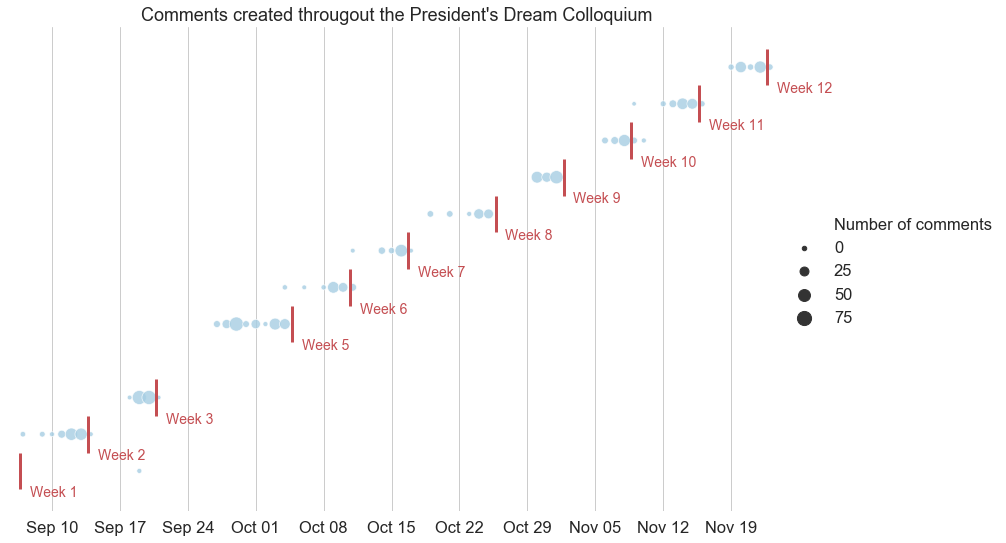

In [289]:
pdf = comments.groupby(["created_day", "week"]).count()['text'].reset_index()
pdf.columns = ['Date', 'Week', 'Number of comments']

g = sns.relplot(x="Date", y="Week", size="Number of comments", alpha=.8,
            sizes=(20,200), palette="muted", data=pdf, height=8, aspect=1.5);
ax = g.facet_axis(0,0)
# ax.legend()
# plt.close(g.fig)

ax.set_xlim((min(pdf.Date)-pd.Timedelta('1 days'), max(pdf.Date)+pd.Timedelta('1 days')));

weekFormatter = mdates.DateFormatter('%b %d');
ax.xaxis.set_major_formatter(weekFormatter);

mondays = mdates.WeekdayLocator(mdates.MONDAY)
ax.xaxis.set_major_locator(mondays)

# plt.gcf().autofmt_xdate();

weeks = list(range(1,13))
plt.yticks(weeks)
for w in readings.week.unique():
    date = classes.loc[w, 'date']
    ax.vlines(date, w-.5, w+.5, colors="r", lw=3, alpha=1)
    plt.text(date+pd.Timedelta("1 days"), w-.7, "Week {}".format(w), fontsize=14, color="r")

plt.xlabel("")
plt.title("Comments created througout the President's Dream Colloquium")
ax.yaxis.set_visible(False)
# ax.xaxis.grid(False)
sns.despine(right=True, top=True, left=True, bottom=True)

if savefigs:
    plt.savefig(str(plot_dir / "week_overview.png"), bbox_inches="tight")

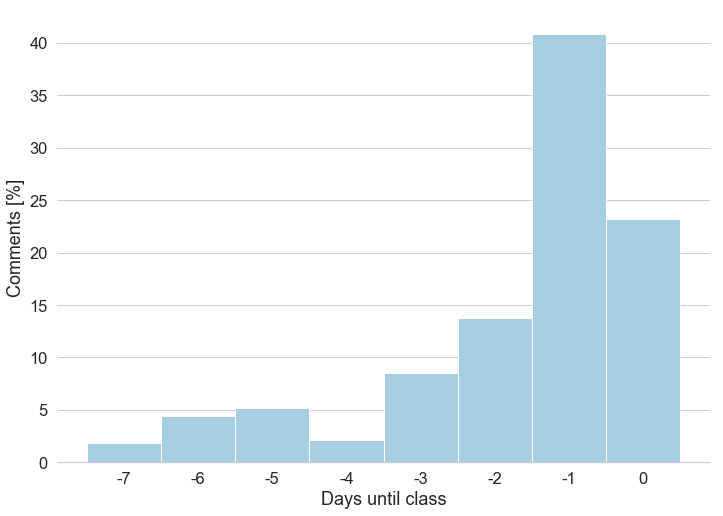

In [290]:
plt.hist(comments.last_minute[comments.last_minute<2], bins=8, normed=True);
plt.xticks([i+.5 for i in range(-7, 1)], list(range(-7, 1)));
plt.xlabel("Days until class");
plt.yticks([0,0.05,0.1,0.15,0.2,0.25,0.3,0.35,.4], ["{}".format(i) for i in range(0,41,5)])
plt.ylabel("Comments [%]")
plt.gca().xaxis.grid(False)
sns.despine(right=True, top=True, left=True)

if savefigs:
    plt.savefig(str(plot_dir / "days_before_class.png"), bbox_inches="tight")

## Comments per part, week, and readings

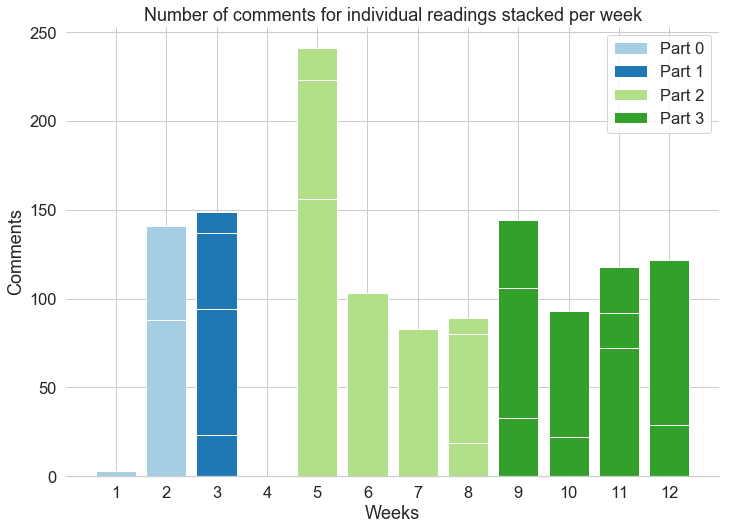

In [293]:
readings_per_week = readings.reset_index().groupby("week")["id"].apply(list)
comments_per_week = comments.groupby("url_id")["url_id"].count()

pdf = pd.DataFrame(columns = ["week", "reading", "comments"])

# f, ax = plt.subplots(figsize=(6, 15))

c = sns.color_palette(n_colors=4)

for w, rs in readings_per_week.items():
    for r in rs:
        rel_readings = readings_per_week.loc[w]
        rel_readings = rel_readings[:rel_readings.index(r)+1]
        pdf.loc[len(pdf)+1] = [w, r, comments_per_week.reindex(rel_readings).sum()]

parts = [0,1,2,3]
for i, row in pdf[::-1].iterrows():
    reading = int(row['reading'])
    week = row['week']
    part = readings.loc[reading].part
    if part in parts:
        label = "Part {}".format(part)
        parts.remove(part)
    else:
        label = None

    plt.bar(week, row['comments'], color=c[part], label=label)

plt.ylabel("Comments")    
plt.xlabel("Weeks")
plt.title("Number of comments for individual readings stacked per week")
plt.xticks(range(1, 13))

handles, labels = plt.gca().get_legend_handles_labels()
plt.legend(handles[::-1], labels[::-1])

sns.despine(right=True, top=True, left=True)

if savefigs:
    plt.savefig(str(plot_dir / "comments_per_reading.png"), bbox_inches="tight")

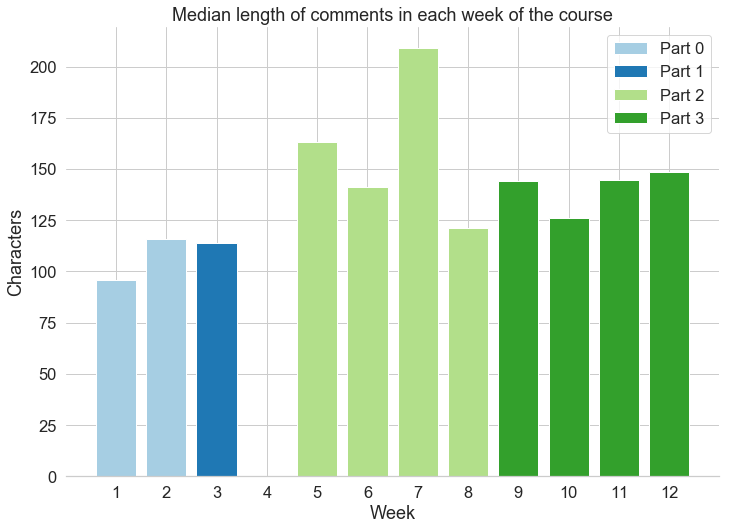

In [284]:
comments_per_week = comments.groupby("week")["length"].median()

parts = [0,1,2,3]
for i, l in comments_per_week.iteritems():
    week = i
    part = readings[readings.week == i].part.iloc[0]
    if part in parts:
        label = "Part {}".format(part)
        parts.remove(part)
    else:
        label = None
        
    plt.bar(i, l, color=c[part], label=label)

plt.legend()
plt.ylabel("Characters")
plt.xlabel("Week")
plt.title("Median length of comments in each week of the course")
plt.xticks(range(1, 13))

sns.despine(right=True, top=True, left=True)

if savefigs:
    plt.savefig(str(plot_dir / "med_comment_length.png"), bbox_inches="tight")

## Comments and median lenghts

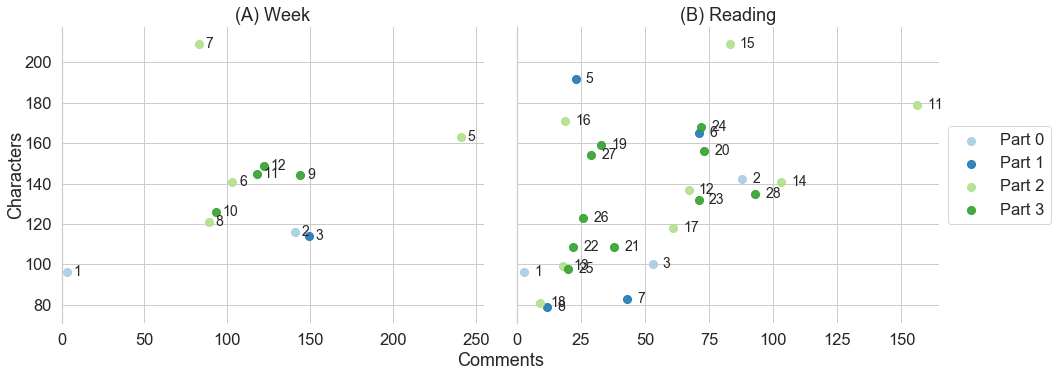

In [285]:
fig, axes = plt.subplots(1,2,figsize=(14,6), sharey=True)

labels = ["(A) Week", "(B) Reading"]
for ax, by, l in zip(axes, ["week", "url_id"], labels):
    df = pd.DataFrame()
    df['comments'] = comments.groupby(by)["length"].count()
    df['length'] = comments.groupby(by)["length"].median()
    df['part'] = df.index.map(lambda x: comments[comments[by]==x].part.iloc[0]).astype("category")
    
    df.reset_index(inplace=True)
    
    for i in range(0,4):
        pdf = df[df.part == i]
        ax.scatter(pdf['comments'], pdf['length'], s=65, alpha=0.9, label = "Part {}".format(i))
    
    for i, row in df.iterrows():
        ax.annotate(int(row[by]),
                    (row['comments']+4, row['length']),
                    horizontalalignment='left',
                    verticalalignment='center',
                    size=14)

    ax.set_title(l)   
    ax.set_xlim(0, ax.get_xlim()[1])
    sns.despine(bottom=True, ax=ax)

box = axes[1].get_position()
axes[1].set_position([box.x0, box.y0, box.width * 0.8, box.height])

# Put a legend to the right of the current axis
axes[1].legend(loc='center left', bbox_to_anchor=(1, 0.5))

fig.add_subplot(111, frameon=False)
plt.tick_params(labelcolor='none', top='off', bottom='off', left='off', right='off')
plt.grid(False)
plt.ylabel("Characters")
plt.xlabel("Comments")

plt.tight_layout()
plt.legend()

if savefigs:
    plt.savefig(str(plot_dir / "comments_vs_length.png"), bbox_inches="tight")

## Parts, weeks, readings per user

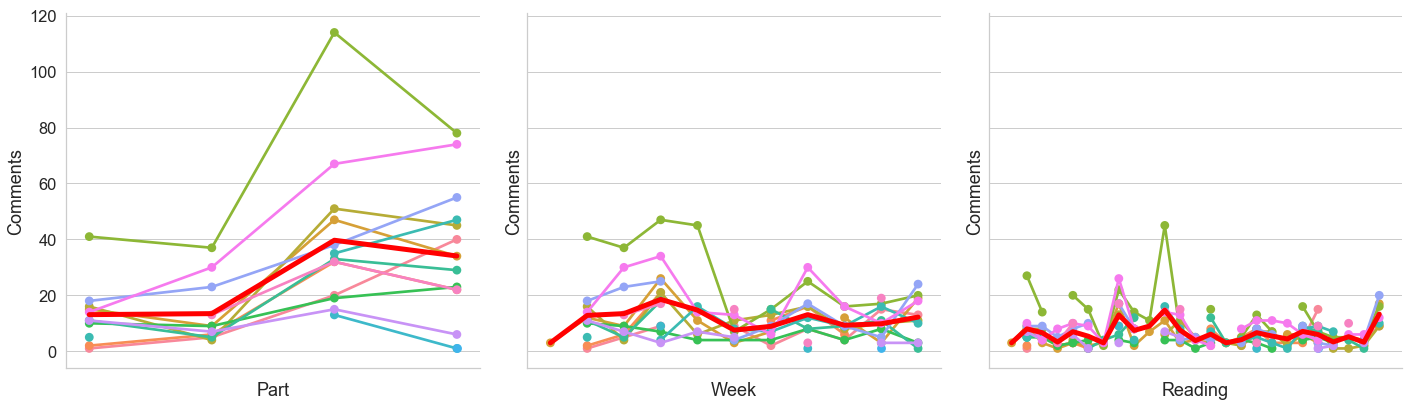

In [247]:
fix, axes = plt.subplots(1,3,figsize=(20,6), sharey=True)
labels = ["Part", "Week", "Reading"]
for ax, by, l in zip(axes, ["part", "week", "url_id"], labels):
    pdf = comments.groupby(["user", by])['text'].count().reset_index()
    sns.pointplot(x=by, y="text", hue="user", data=pdf, ax=ax,  lw=1)
    
    x = pdf.groupby([by]).mean()
    ax.plot(x.text.values, c="red", lw="5", zorder=100)

    ax.legend_.remove()
    ax.set_xlabel(l);
    ax.set_xticklabels([])
    ax.set_ylabel("Comments")
    sns.despine(right=True, top=True, ax=ax)
plt.tight_layout()

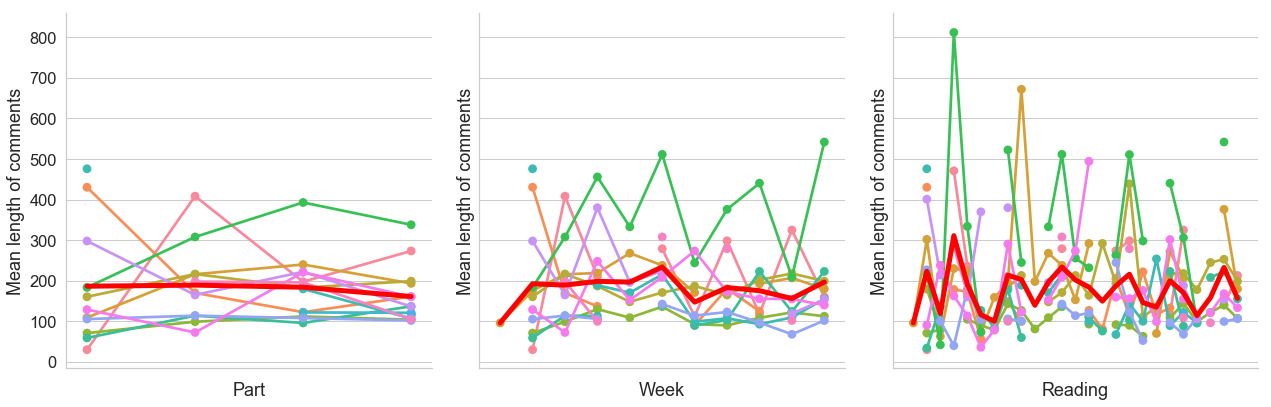

In [248]:
fix, axes = plt.subplots(1,3,figsize=(18,6), sharey=True)
labels = ["Part", "Week", "Reading"]
for ax, by, l in zip(axes, ["part", "week", "url_id"], labels):
    pdf = comments.groupby(["user", by])['length'].median().reset_index()
    sns.pointplot(x=by, y="length", hue="user", data=pdf, ax=ax,  lw=1)
    
    x = pdf.groupby([by]).mean()
    ax.plot(x.length.values, c="red", lw="5", zorder=100)

    ax.legend_.remove()
    ax.set_xlabel(l);
    ax.set_xticklabels([])
    ax.set_ylabel("Mean length of comments")
    sns.despine(right=True, top=True, ax=ax)
plt.tight_layout()

## Number of comments and the median length

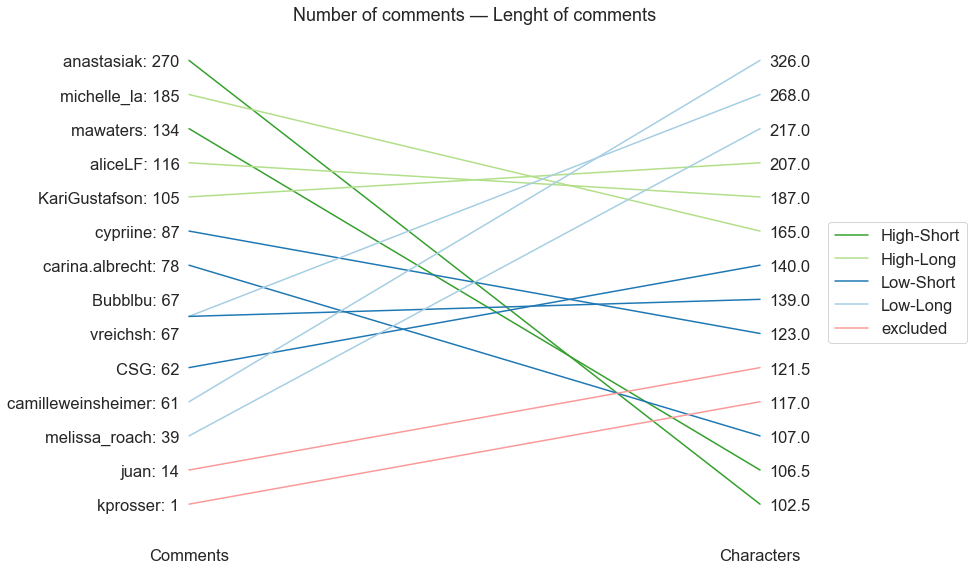

In [286]:
counts = pd.DataFrame(columns=["total", "median"])
counts['total'] = comments.user.value_counts()
counts['median'] = comments.groupby("user")["text"].apply(lambda x: median([len(str(y)) for y in x.tolist()]))
# counts.rank(ascending=False).T.plot(legend=False)

groups = {
    "High-Long": ["aliceLF", "KariGustafson", "michelle_la"],
    "High-Short": ["anastasiak", "mawaters"],
    "Low-Long": ["Bubblbu", "camilleweinsheimer", "melissa_roach"], 
    "Low-Short": ["carina.albrecht", "cypriine", "CSG", "vreichsh"],
}

col = sns.color_palette(n_colors=5)
pdf = counts.rank(ascending=False)
labels = []
for i, row in pdf.iterrows():
    l = None
    c = None
    for ix, (g, names) in enumerate(groups.items()):
        if i in names:
            l = g
            c = col[ix]        
    if not l:
        l = "excluded"
        c = col[-1]
        
    plt.plot([row['total'],row['median']], label=l if l not in labels else "", c=c)
    labels.append(l)
    
# plt.legend(loc="right")
# Shrink current axis by 20%
ax = plt.gca()
box = ax.get_position()
ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])

# Put a legend to the right of the current axis
ax.legend(loc='center left', bbox_to_anchor=(1.05, 0.5))

ax1 = plt.gca()
ax1.set_ylim((0,15))

ax2 = ax1.twinx()
ax2.set_ylim((0,15))

ax1.set_yticks(range(1, 15))
ax2.set_yticks(range(1, 15))

labels_1 = []
for k, v in counts['total'].items():
    labels_1.append("{}: {}".format(k, v))
ax1.set_yticklabels(labels_1)

labels_2 = []
for k, v in counts['median'].sort_values().items():
    labels_2.append("{}".format(v))
ax2.set_yticklabels(labels_2)

ax1.invert_yaxis()

plt.title("Number of comments — Lenght of comments")
plt.xticks([0,1], ["Comments", "Characters"]);
ax1.grid(False)
ax2.grid(False)
ax1.yaxis.set_ticks_position('none')
ax2.yaxis.set_ticks_position('none')
ax1.tick_params(axis='y', pad=-25)
ax2.tick_params(axis='y', pad=-25)

# plt.subplots_adjust(hspace=0)


plt.tight_layout()
sns.despine(right=True, top=True, bottom=True, left=True, trim=True)

if savefigs:
    plt.savefig(str(plot_dir / "user_ranks_length_vs_comments.png"), bbox_inches="tight")

### Reading Times

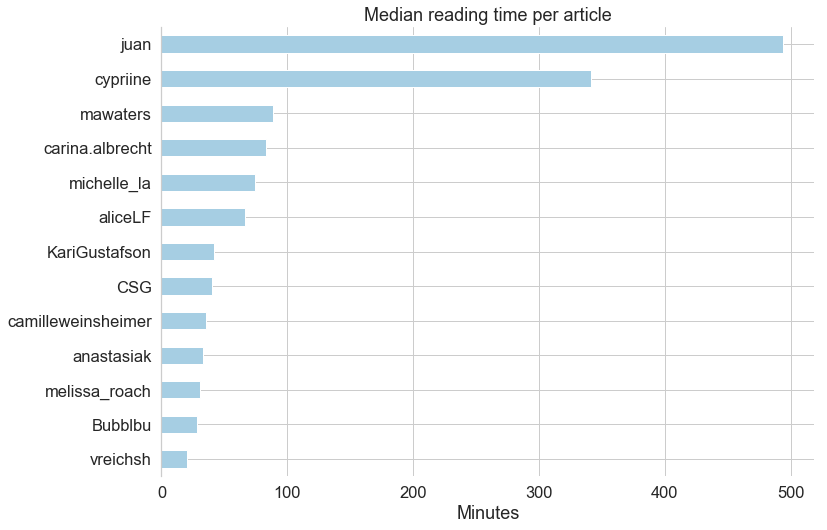

In [287]:
reading_times = pd.DataFrame(columns=["url_id", "week", "part", "user", "mins", "comments"])

for user in usernames:
    for uid in comments.url_id.unique():
        c = comments[(comments.user==user)&(comments.url_id==uid)]
        count = len(c)
        if count > 1:
            reading_time = max(c.created)-min(c.updated)
            reading_time = int(reading_time.seconds // 60)
            reading_times.loc[len(reading_times)+1] = [uid, c.week.iloc[0], c.part.iloc[0], user, reading_time, count]
reading_times.mins = reading_times.mins.astype(int)
reading_times.comments = reading_times.comments.astype(int)
pd.DataFrame(reading_times.groupby("user")['mins'].median()).sort_values(by="mins").plot(kind="barh", legend=False)
plt.title("Median reading time per article")
plt.xlabel("Minutes")
plt.ylabel("")
sns.despine(right=True, top=True, bottom=True)

if savefigs:
    plt.savefig(str(plot_dir / "reading_times.png"), bbox_inches="tight")

## Comments with URLs

What about annotations that link to other material?
Is that a particularly engaging activity?

In [88]:
comments['Has URL'].sum()/

0.08242612752721618

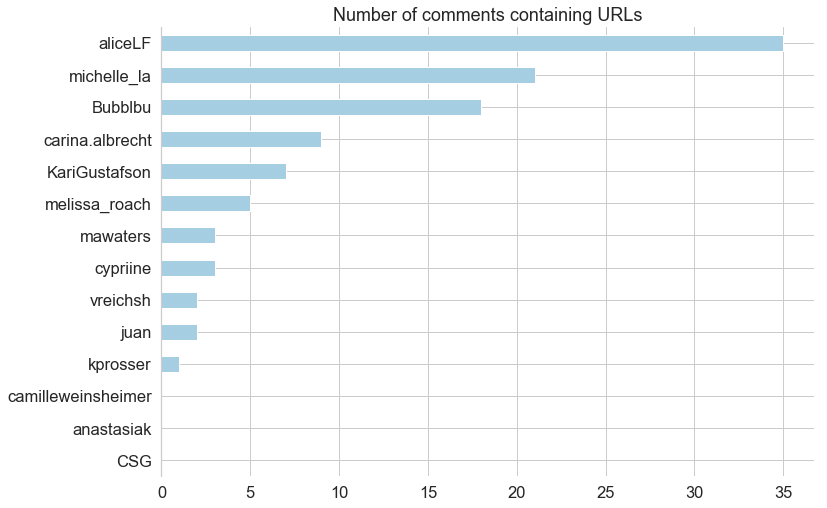

In [288]:
pdf = comments.groupby("user")['Has URL'].apply(lambda x: sum([int(y) if not pd.isna(y) else 0 for y in x]))
pd.DataFrame(pdf).sort_values(by="Has URL").plot(kind="barh", legend=False)
plt.title("Number of comments containing URLs")
plt.ylabel("")
sns.despine(right=True, bottom=True, top=True)

if savefigs:
    plt.savefig(str(plot_dir / "comments_with_urls.png"), bbox_inches="tight")

## Number of comments as a measure of engagement

In [261]:
df = pd.DataFrame(columns=['part', 'survey_part', 'week', 'survey_week', 'reading', 'survey_reading'])
by = "text"

x = comments.groupby(["user", "part"])[by].count().reset_index()
df['part'] = x.groupby("user").apply(lambda x: x.loc[x[by].idxmax()])['part']

x = comments.groupby(["user", "week"])[by].count().reset_index()
df['week'] = x.groupby("user").apply(lambda x: x.loc[x[by].idxmax()])['week']

x = comments.groupby(["user", "url_id"])[by].count().reset_index()
df['reading'] = x.groupby("user").apply(lambda x: x.loc[x[by].idxmax()])['url_id']

df['survey_part'] = eng_survey['eng_part']
df['survey_week'] = eng_survey['eng_week']
df['survey_reading'] = eng_survey['eng_reading']
df = df.dropna()

cols = ["part", "week", "reading"]
matches = pd.DataFrame(columns=cols)
for c in cols:
    for i in df.index.tolist():
        if not pd.isna(df.loc[i, c]) and not pd.isna(df.loc[i, "survey_" + c]):
            survey_max = df.loc[i,"survey_" + c]
            if c=="reading":
                d = "url_id"
            else:
                d = c
            ranks = comments.groupby(["user", d])['text'].count()[i].rank(ascending=False)
            if survey_max in ranks:
                pos = ranks.loc[survey_max]
            else:
                pos = len(ranks)
            matches.loc[i, c] = pos
        else:
            matches.loc[i, c] = None
matches_count = matches

## Length of comments as engagement

In [262]:
df = pd.DataFrame(columns=['part', 'survey_part', 'week', 'survey_week', 'reading', 'survey_reading'])

by = "length"
x = comments.groupby(["user", "part"])[by].mean().reset_index()
df['part'] = x.groupby("user").apply(lambda x: x.loc[x[by].idxmax()])['part']

x = comments.groupby(["user", "week"])[by].mean().reset_index()
df['week'] = x.groupby("user").apply(lambda x: x.loc[x[by].idxmax()])['week']

x = comments.groupby(["user", "url_id"])[by].mean().reset_index()
df['reading'] = x.groupby("user").apply(lambda x: x.loc[x[by].idxmax()])['url_id']

df['survey_part'] = eng_survey['eng_part']
df['survey_week'] = eng_survey['eng_week']
df['survey_reading'] = eng_survey['eng_reading']
df = df.dropna()

cols = ["part", "week", "reading"]
matches = pd.DataFrame(columns=cols)
for c in cols:
    for i in df.index.tolist():
        if not pd.isna(df.loc[i, c]) and not pd.isna(df.loc[i, "survey_" + c]):
            survey_max = df.loc[i,"survey_" + c]
            if c=="reading":
                d = "url_id"
            else:
                d = c
            ranks = comments.groupby(["user", d])['length'].mean()[i].rank(ascending=False)
            if survey_max in ranks:
                pos = ranks.loc[survey_max]
            else:
                pos = len(ranks)
            matches.loc[i, c] = pos
        else:
            matches.loc[i, c] = None
matches_length = matches

In [314]:
x = readings[['title', 'type', 'author', 'url', 'total']]
x.columns = ["Title", "Type", "Authors", "URL", "Comments"]
x.index.name = ""
print(tabulate(x, tablefmt="pipe", headers="keys"))

|    | Title                                                                                                                                                     | Type         | Authors                                                                                                               | URL                                                                                                                                                                     |   Comments |
|---:|:----------------------------------------------------------------------------------------------------------------------------------------------------------|:-------------|:----------------------------------------------------------------------------------------------------------------------|:------------------------------------------------------------------------------------------------------------------------------------------------------------------------|-----------:|
|  1 | The Access Principle: The Case 

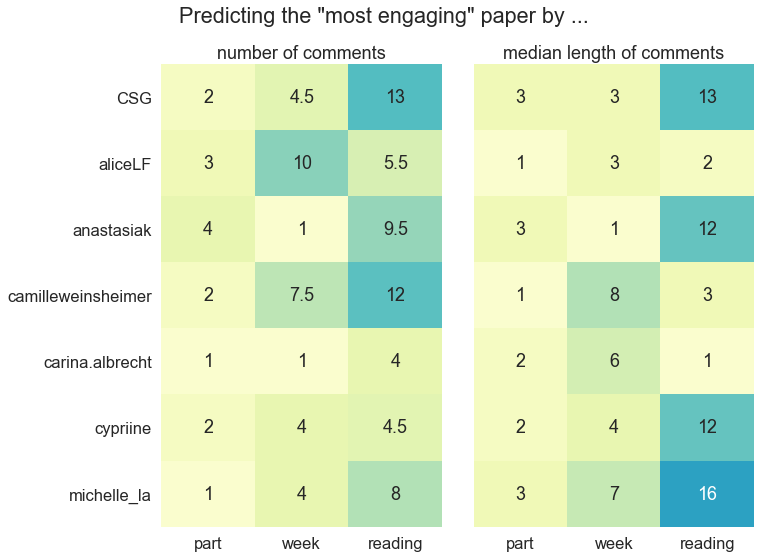

In [266]:
fig, axes = plt.subplots(1,2, sharey=True, sharex=True, figsize=(11,8))
titles = ["number of comments", "median length of comments"]
for ax, pdf, t in zip(axes, [matches_count, matches_length], titles):
    pdf = pdf.astype(float).dropna()
    sns.heatmap(data=pdf.values, vmin=0, vmax=28, annot=True, cbar=False, cmap="YlGnBu", ax=ax)
    ax.set_xticks([0.5,1.5,2.5])
    ax.set_xticklabels(["part", "week", "reading"]);
    ax.set_yticks([i-.5 for i in range(1, len(pdf)+1)])
    ax.set_yticklabels(pdf.index.values, rotation=0);
    ax.set_title(t);
plt.suptitle("Predicting the \"most engaging\" paper by ...");
plt.tight_layout()
plt.gcf().subplots_adjust(top=0.88)

if savefigs:
    plt.savefig(str(plot_dir / "engagement_predictors.png"), bbox_inches="tight")

In [93]:
df = pd.DataFrame.from_dict({"part":4, "week":12, "reading":28}, orient="index", columns=["n"])
df['count_accuracy'] = (df.n-matches_count.mean())/(df.n-1)
df['length_accuracy'] = (df.n-matches_length.mean())/(df.n-1)
df

,n,count_accuracy,length_accuracy
reading,28,0.735450,0.724868
week,12,0.675325,0.675325
part,4,0.619048,0.619048
